# Introduction

In this notebook we demonstrate the solution of simple linear transport equations such as

$$
\begin{align}
    -\epsilon \Delta u + b \cdot \nabla u &= f \qquad x \in \Omega \\
    u &= 0 \qquad x \in \partial \Omega
\end{align}
$$

where $\epsilon > 0$ is a (small) parameter, $b$ a given vector field and $f$ a given 
function. For this problem to be well posed it is required that $\nabla \cdot b = 0$.

There are two operators, the diffusion operator $-\epsilon \Delta$ which acts to smooth
out the source proportionally to $\epsilon$, and the transport operator 
$b \cdot \nabla u$ which acts to transport infinitesimal volumes of $u$ in the direction
of the vector field $b$. These two operators model the physical processes of diffusion
and convection respectively.

In [1]:
import tenfem
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.collections import LineCollection

tf_dtype = tf.float32

eps = 0.1 # the small constant multiplying the diffusion term
function_space_deg = 2

In [2]:
mesh = tenfem.mesh.examples.circle(0.1, dtype=tf_dtype)

element = tenfem.reference_elements.TriangleElement(degree=function_space_deg, dtype=tf_dtype)

if function_space_deg == 2:
    mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)
    mesh.add_matplotlib_tri()

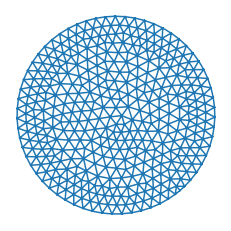

In [3]:
fig, ax = plt.subplots()
ax.triplot(mesh._triang)
ax.set_aspect('equal'); ax.axis('off')
plt.show()

In [4]:
def transport_vector_field(x):
    """ Returns a vector [1, 1] at each spatial coordinate of x. 
    
    Args:
        x: A float `Tensor` of shape `[..., 2]`.
    
    Returns:
        tvf: A float `Tensor` of shape `[..., 2]` giving the
          vector field at each coordinate.
    """
    return tf.ones_like(x)[..., tf.newaxis] * tf.ones([2])

# create the PDE model
poisson_layer = tenfem.layers.LinearEllipticOperator(
    diffusion_coefficient = lambda x: 0.1*tf.ones_like(x[..., 0]),
    source = lambda x: tf.ones_like(x[..., 0]),
    boundary_condition='dirichlet',
    boundary_values = lambda x: tf.zeros_like(x[..., 0])[..., tf.newaxis],
    reference_element=element)

pde_layer = tenfem.layers.LinearEllipticOperator(
    diffusion_coefficient = lambda x: 0.1*tf.ones_like(x[..., 0]),
    source = lambda x: tf.ones_like(x[..., 0]),
    transport_vector_field = transport_vector_field,
    boundary_condition='dirichlet',
    boundary_values = lambda x: tf.zeros_like(x[..., 0])[..., tf.newaxis],
    reference_element=element)


The solution is plotted below, next to the same solution for the model with no transport.
We can clearly see that the mass injected by the source is "pushed" in the direction of
the transport vector. We can also observe the *boundary* layer, where the relatively
large value of the of the transported mass must also rapidly decrease to zero in order
to satisfy the boundary conditions.

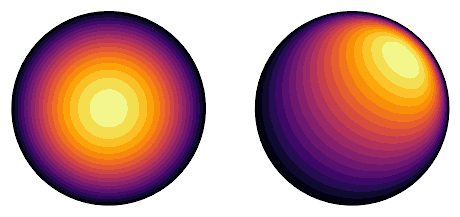

In [7]:
u = pde_layer(mesh.get_tensor_repr())
u_poisson = poisson_layer(mesh.get_tensor_repr())

mtri = Triangulation(*mesh.nodes.numpy().T)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].tricontourf(mtri, u_poisson[:, 0], levels=20, cmap='inferno')
axes[1].tricontourf(mtri, u[:, 0], levels=20, cmap='inferno')

for ax in axes.flatten():
    ax.set_aspect('equal'); ax.axis('off')
    ax.add_collection(
        LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), 
                       colors='k', label='$\partial \Omega$'))
    ax.set_xlim((-1.05, 1.05))
    ax.set_ylim((-1.05, 1.05))
    
plt.show()